In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.run_model as rm
from collections import OrderedDict
import matplotlib.pyplot as plt

##  Group vs. individual variance
For each data set seperately, determine the variance that is explained by group, subject and measurement noise, un L2Half models. 

Make a nice plot


In [10]:
# configs
dataset_list = ["MDTB", "Language", "Social", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
logalpha_list = [6, 4, 6, 6, 0, 0, 8, 4]

In [11]:
# Load the product matrix and metadata vectors 
data = np.load("/home/UWO/ashahb7/Github/bayes_temp/L2reghalf_cov_matrix.npz", allow_pickle=True)
indices = []
for ds, la in zip(dataset_list, logalpha_list):
    indices.append(np.where((data['dataset_vec'] == ds) & (data['logalpha_vec'] == la))[0])
indices = np.concatenate(indices)
product_la = data['product_matrix'][np.ix_(indices, indices)]
dataset_vec_la = data['dataset_vec'][indices]
sub_vec_la = data['sub_vec'][indices]
part_vec_la = data['part_vec'][indices]

# Calculate the norm of each original vector to convert covariance matrix to cosine similarity matrix
norm_vec = np.zeros(len(dataset_vec_la))
norm_vec = np.sqrt(np.diag(product_la))# * (1876 * 5446))
sim_la = product_la / np.outer(norm_vec, norm_vec)

### Plot the cosine similarity matrix

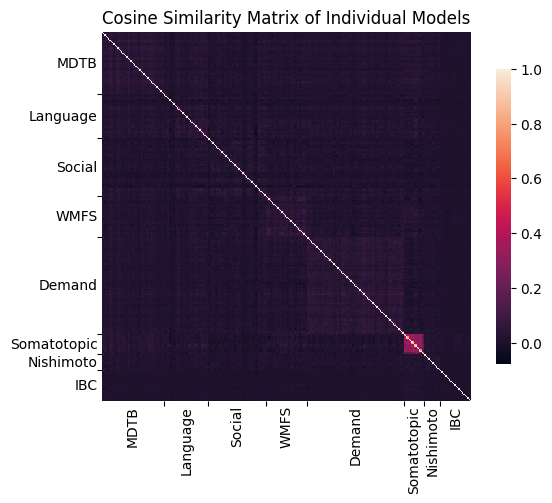

In [12]:
data_to_plot = sim_la.copy()

# Set diagonal elements to 0
# np.fill_diagonal(data_to_plot, 0)
# for i in range(data_to_plot.shape[0]):
#     if i > 0:
#         data_to_plot[i, i - 1] = 0
#     if i < data_to_plot.shape[0] - 1:
#         data_to_plot[i, i + 1] = 0

sns.heatmap(data_to_plot, square=True, cbar_kws={'shrink': 0.8})

# Remove numbers on x and y ticks
plt.xticks([])
plt.yticks([])
plt.title("Cosine Similarity Matrix of Individual Models")

# Add block labels for datasets
unique_datasets = list(OrderedDict.fromkeys(dataset_vec_la))
dataset_start_indices = [np.where(dataset_vec_la == ds)[0][0] for ds in unique_datasets]

for i, start_idx in enumerate(dataset_start_indices):
    end_idx = dataset_start_indices[i + 1] if i + 1 < len(dataset_start_indices) else len(dataset_vec_la)
    mid_idx = (start_idx + end_idx) // 2
    plt.text(mid_idx, len(dataset_vec_la)+3, unique_datasets[i], ha='center', va='top', fontsize=10, rotation=90, color='black')
    plt.text(-3, mid_idx, unique_datasets[i], ha='right', va='center', fontsize=10, color='black')

# Add ticks in the x-axis and y-axis for dataset blocks without labels
plt.xticks(dataset_start_indices[1:], []);
plt.yticks(dataset_start_indices[1:], []);

### Do Variance Decomposition

In [13]:
ds_var_decom_df = pd.DataFrame()
for dataset_name in dataset_list:
    print(f"\nDecomposing Variance for Dataset: {dataset_name}")
    subset_indices = np.where(dataset_vec_la == dataset_name)[0]
    product_subset = product_la[np.ix_(subset_indices, subset_indices)]
    dataset_subset = dataset_vec_la[subset_indices]
    sub_subset = sub_vec_la[subset_indices]
    part_subset = part_vec_la[subset_indices]

    # Solve
    df = rm.decompose_variance_scaled_from_SS(product_subset, dataset_subset, sub_subset, part_subset, single_scaling=True)
    ds_var_decom_df = pd.concat([ds_var_decom_df, df], ignore_index=True)


Decomposing Variance for Dataset: MDTB
The number of unique datasets is 1. Universal Variance (v_u) cannot be estimated. Returning v_g as v_u + v_d.
Bad pairs (cross-subject): 0.18%
Bad pairs (cross-partition): 0.00%
Bad pairs (same-partition): 0.00%

Decomposing Variance for Dataset: Language
The number of unique datasets is 1. Universal Variance (v_u) cannot be estimated. Returning v_g as v_u + v_d.
Bad pairs (cross-subject): 9.74%
Bad pairs (cross-partition): 0.00%
Bad pairs (same-partition): 0.00%

Decomposing Variance for Dataset: Social
The number of unique datasets is 1. Universal Variance (v_u) cannot be estimated. Returning v_g as v_u + v_d.
Bad pairs (cross-subject): 16.23%
Bad pairs (cross-partition): 0.00%
Bad pairs (same-partition): 0.00%

Decomposing Variance for Dataset: WMFS
The number of unique datasets is 1. Universal Variance (v_u) cannot be estimated. Returning v_g as v_u + v_d.
Bad pairs (cross-subject): 1.46%
Bad pairs (cross-partition): 0.00%
Bad pairs (same-par

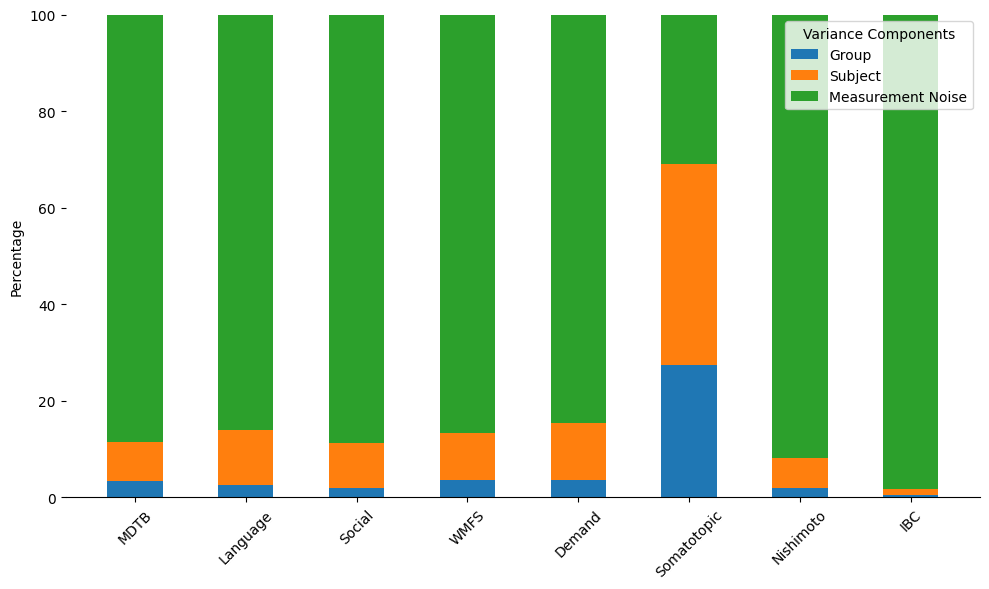

In [31]:
# Initialize an empty DataFrame to store mean percentages for each dataset
mean_percentages_list = []

# Loop through each dataset
for dataset_name in dataset_list:
    subset_df = ds_var_decom_df[ds_var_decom_df['train_dataset'] == dataset_name].copy().reset_index(drop=True)
    
    subset_df['total_variance'] = subset_df['v_g'] + subset_df['v_s'] + subset_df['v_m']
    subset_df['v_g_percentage'] = (subset_df['v_g'] / subset_df['total_variance']) * 100
    subset_df['v_s_percentage'] = (subset_df['v_s'] / subset_df['total_variance']) * 100
    subset_df['v_m_percentage'] = (subset_df['v_m'] / subset_df['total_variance']) * 100
    
    # Calculate the mean percentages for the current dataset
    mean_percentages = subset_df[['v_g_percentage', 'v_s_percentage', 'v_m_percentage']].mean()
    mean_percentages.name = dataset_name
    
    mean_percentages_list.append(mean_percentages)

# Combine all mean percentages into a single DataFrame
mean_percentages = pd.DataFrame(mean_percentages_list, index=dataset_list)

# Create a single stacked bar plot
x = dataset_list
width = 0.5

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x, mean_percentages['v_g_percentage'], width, label='Group', color='#1f77b4')
bar2 = ax.bar(x, mean_percentages['v_s_percentage'], width, bottom=mean_percentages['v_g_percentage'], label='Subject', color='#ff7f0e')
bar3 = ax.bar(x, mean_percentages['v_m_percentage'], width, bottom=mean_percentages['v_g_percentage'] + mean_percentages['v_s_percentage'], label='Measurement Noise', color='#2ca02c')

# Add labels and title
ax.set_ylabel('Percentage')
ax.set_ylim(0, 100)
ax.set_xticks(range(len(dataset_list)))
ax.set_xticklabels(dataset_list, rotation=45, ha='center')
# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add legend
ax.legend(title='Variance Components')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

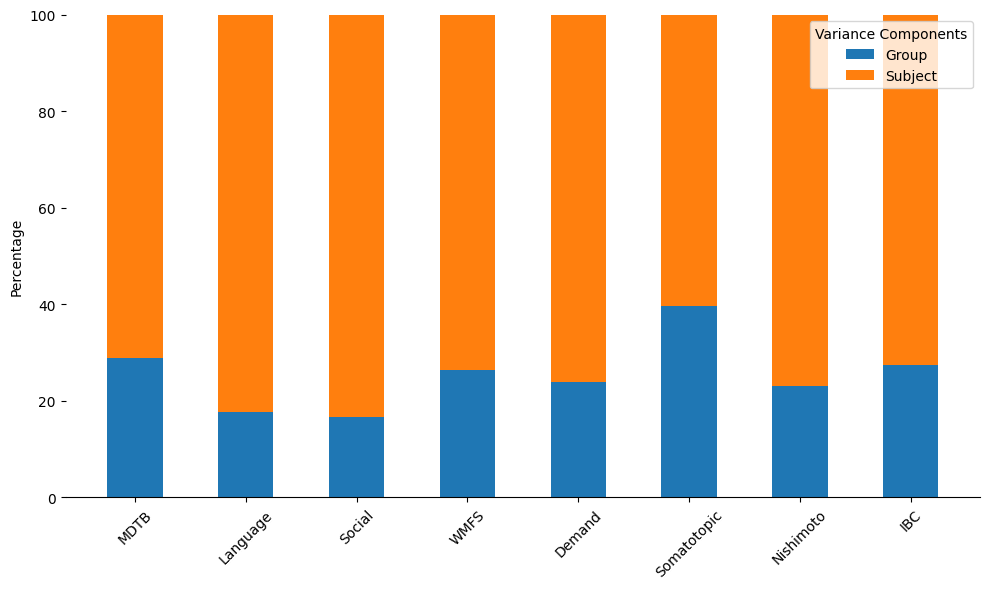

In [32]:
# Initialize an empty DataFrame to store mean percentages for each dataset
mean_percentages_list = []

# Loop through each dataset
for dataset_name in dataset_list:
    subset_df = ds_var_decom_df[ds_var_decom_df['train_dataset'] == dataset_name].copy().reset_index(drop=True)
    
    subset_df['total_variance'] = subset_df['v_g'] + subset_df['v_s']
    subset_df['v_g_percentage'] = (subset_df['v_g'] / subset_df['total_variance']) * 100
    subset_df['v_s_percentage'] = (subset_df['v_s'] / subset_df['total_variance']) * 100
    
    # Calculate the mean percentages for the current dataset
    mean_percentages = subset_df[['v_g_percentage', 'v_s_percentage']].mean()
    mean_percentages.name = dataset_name
    
    mean_percentages_list.append(mean_percentages)

# Combine all mean percentages into a single DataFrame
mean_percentages = pd.DataFrame(mean_percentages_list, index=dataset_list)

# Create a single stacked bar plot
x = dataset_list
width = 0.5

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x, mean_percentages['v_g_percentage'], width, label='Group', color='#1f77b4')
bar2 = ax.bar(x, mean_percentages['v_s_percentage'], width, bottom=mean_percentages['v_g_percentage'], label='Subject', color='#ff7f0e')

# Add labels and title
ax.set_ylabel('Percentage')
ax.set_ylim(0, 100)
ax.set_xticks(range(len(dataset_list)))
ax.set_xticklabels(dataset_list, rotation=45, ha='center')
# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add legend
ax.legend(title='Variance Components')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()